In [ ]:
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
import math
# import metrics
# from metrics import *
import ast
import sklearn
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import hamming_loss
#from annoy import AnnoyIndex
import tensorflow_hub as hub
import tensorflow as tf
import json
import torch

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
with open('/content/drive/MyDrive/Project-data/Wiki-text/104_117_data_new_regrouped_annotated.json') as fin:
  data = json.load(fin)

In [ ]:
print(len(data))

1631


In [ ]:
data[0]

{'Background': '\nHeflin was born on June 19, 1921, in Poulan, Georgia.  He attended public school in Alabama, graduating from Colbert County High School in Leighton.[1]  He earned his Bachelor of Arts degree in 1942 from Birmingham-Southern College in Birmingham.[2]  There was a tradition of politics in his family: he was a nephew of James Thomas Heflin, a prominent white supremacist politician and U.S. Senator, and great-nephew of Robert Stell Heflin, a U.S. Representative.\n\nDuring World War II, from 1942 to 1946, Heflin served as an officer in the United States Marine Corps.[3] He was awarded the Silver Star for valor in combat and received two Purple Heart medals,[4] having seen action on Bougainville and Guam.\n\nAfter World War II, Heflin attended the University of Alabama School of Law, from which he graduated in 1948. For nearly two decades, he served as a law professor, while concurrently practicing law in Tuscumbia, Alabama.[4]\n\nThe University of Alabama School of Law has

In [ ]:
names = []
duplicate = []
index = []
for i,member in enumerate(data):
  if member['Name'] not in names:
    names.append(member['Name'])
    index.append(i)
  else:
    duplicate.append(member['Name'])
print(duplicate)

['Carol Moseley Braun', 'Jim Inhofe', 'Bob Matsui', 'Luis Gutiérrez', 'Phil Crane', 'Sidney R. Yates', 'Harris W. Fawell', 'James Traficant', 'Sheila Jackson Lee', 'Richard Lugar', 'Bill Lipinski', 'Pete Hoekstra', 'Dave Camp', 'Nick Smith (American politician)', 'Gene Taylor (Mississippi politician)', 'Jim Saxton', 'Fritz Hollings', 'Buck McKeon', 'Norm Dicks', 'Jim Talent', 'J. D. Hayworth', 'Ed Royce', 'Duke Cunningham', 'Susan Davis (politician)', 'John B. Larson', 'Clay Shaw (politician)', 'Jan Schakowsky', 'Tim Johnson (Illinois politician)', 'Don Manzullo', 'Dan Burton', 'Billy Tauzin', 'Richard Baker (American politician)', 'Chris John', 'Jim McGovern (American politician)', 'Stephen F. Lynch', 'Tom Osborne', 'Mike Ferguson (New Jersey politician)', 'Bill Pascrell', 'Rush Holt Jr.', 'Joe Hoeffel', 'Mike Doyle (American politician)', 'Pat Toomey', 'Joe Pitts (Pennsylvania politician)', 'Joe Wilson (American politician)', 'Jim Turner (politician)', 'Eni Faleomavaega', 'Joe Lieber

In [ ]:
len(index)

1492

In [ ]:
temp_data = []
for i in index:
  temp_data.append(data[i])

In [ ]:
with open("/content/drive/MyDrive/Project-data/Wiki-text/cleaned_removed_duplicates.json", 'w') as outfile:
    json.dump(temp_data, outfile)

In [ ]:
with open('/content/drive/MyDrive/Project-data/Wiki-text/104_117_removed_duplicates_without_other_party_annotated.json') as fin:
  data = json.load(fin)

In [ ]:
len(data)

1376

In [ ]:
text = []
for i,representative in enumerate(data):
  #inner_text = []
  inner_text = ""
  for keys in representative.keys():
    if(keys not in ['Name','PersonalDetails']):
      #inner_text.append(representative[keys])
      #print(representative[keys])
      inner_text += str(representative[keys]) + " "  
  text.append(inner_text)

In [ ]:
other_length=[]
political_length=[]
background_length=[]

other_greater_than_4096 = 0
background_greater_than_4096 = 0
political_greater_than_4096 = 0

political=[]
background = []
max_length=0
for i in range(len(data)):
  political.append(len(data[i]['Political']))
  background.append(len(data[i]['Background']))
  if(len(data[i]['Others'])>4096):
    other_greater_than_4096+=1
    other_length.append(i)

  if(len(data[i]['Background'])>4096):
    background_greater_than_4096+=1
    background_length.append(i)

  if(len(data[i]['Political'])>4096):
    if len(data[i]['Political'])>max_length:
      max_length=len(data[i]['Political'])
    political_greater_than_4096+=1
    political_length.append(i)

print(other_greater_than_4096)
print(background_greater_than_4096)
print(political_greater_than_4096)

85
296
862


In [ ]:
print(max_length)

70482


In [ ]:
common=list(set(political_length) & set(background_length))
print(common)

[1, 4, 517, 7, 8, 1031, 10, 523, 524, 1035, 14, 1037, 1039, 17, 20, 21, 1046, 535, 24, 537, 1049, 27, 29, 30, 543, 1055, 1057, 35, 1059, 1061, 38, 39, 552, 1063, 554, 43, 44, 1066, 46, 559, 49, 1073, 51, 52, 1075, 55, 1080, 1081, 58, 572, 61, 1086, 64, 578, 579, 1091, 69, 70, 71, 72, 73, 74, 583, 1093, 589, 1094, 594, 598, 610, 1123, 612, 102, 616, 106, 620, 110, 622, 1136, 625, 116, 628, 629, 631, 1141, 1148, 1149, 638, 639, 642, 1157, 646, 1159, 1162, 140, 142, 143, 145, 1169, 149, 150, 1174, 1175, 1176, 1180, 671, 1187, 1188, 677, 678, 1191, 1192, 682, 172, 685, 1198, 690, 694, 188, 189, 1213, 1215, 193, 706, 1218, 196, 198, 1222, 200, 1223, 1227, 717, 209, 213, 214, 215, 727, 1238, 221, 1252, 742, 1254, 744, 236, 239, 240, 752, 1267, 245, 1270, 247, 250, 252, 764, 255, 767, 769, 259, 772, 773, 774, 1291, 1297, 786, 275, 1300, 277, 790, 1311, 1314, 804, 806, 296, 1323, 813, 814, 816, 817, 1328, 1332, 309, 822, 824, 825, 314, 827, 318, 831, 832, 322, 836, 838, 839, 328, 841, 330, 845

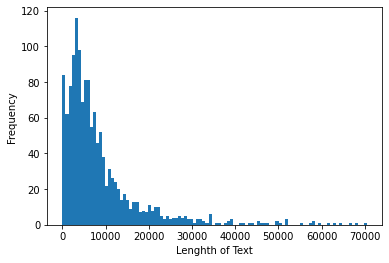

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.hist(political, bins=100,density=False)  # density=False would make counts
plt.ylabel('Frequency')
plt.xlabel('Lenghth of Text');

In [ ]:
print(max(political_length))

1375


In [ ]:
# Y = []
# for i,t in enumerate(data):
#   try:
#     Y.append(t['PersonalDetails']['Political party'])
#   except:
#     Y.append("Party-NA")
# print(Y)

In [ ]:
# '''
# Solved people who did not shift parties
# '''
# rcount=0
# dcount = 0
# other_count = 0
# other=[]
# for i in range(len(Y)):
#   if (Y[i] == 'Republican' or Y[i] == 'Republican[1]'):
#       # print(Y[i])
#       rcount +=1
#   elif (Y[i] == 'Democratic' or Y[i] == 'Democratic[1]'):
#       # print(Y[i])
#       dcount+=1
#   else:
#     # print(Y[i])
#     # print(data[i]['Name'])
#     other.append(i)
#     other_count += 1
# print(rcount," republicans")
# print(dcount," democrats")
# print(other_count,"others")
# print(other)

In [ ]:
# "DELETE those who shifted party"
# new_data=[]
# for idx in range(len(data)):
#   if idx not in other:
#       new_data.append(data[idx])

In [ ]:
# print(len(new_data))

In [ ]:
# with open("/content/drive/MyDrive/Project-data/Wiki-text/104_117_without_other_party_annotated.json", 'w') as outfile:
    # json.dump(new_data, outfile)

In [ ]:
Y = []
for i,t in enumerate(data):
  try:
    Y.append(t['PersonalDetails']['Political party'])
  except:
    Y.append("Party-NA")
print(Y)

['Democratic', 'Republican', 'Republican', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Republican', 'Democratic', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Republican', 'Republican', 'Republican', 'Republican', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Democratic', 'Republican', 'Republican', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Republican', 'Republican', 'Republican', 'Republican', 'Democratic', 'Republican', 'Republican', 'Democratic', 'Democratic', 'Democratic', 'Republican', 'Republican', 'Repu

In [ ]:
new_y = Y
for i in range(len(Y)):
  if(Y[i][0]=='D'):
    new_y[i] = 0
  else:
    new_y[i] = 1
print(new_y)

[0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 

In [ ]:
print(len(new_y))

1376


In [ ]:
!pip install -U sentence-transformers

     |████████████████████████████████| 78 kB 4.7 MB/s 
     |████████████████████████████████| 3.3 MB 18.1 MB/s 
     |████████████████████████████████| 3.3 MB 53.5 MB/s 
     |████████████████████████████████| 1.2 MB 48.3 MB/s 
     |████████████████████████████████| 61 kB 487 kB/s 
     |████████████████████████████████| 596 kB 41.6 MB/s 
     |████████████████████████████████| 895 kB 48.8 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=3eaa221b0b8acb5b5dfaffaa9488cffcc8ccf8d79340cfd1be43f5f17aaf42a4
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
background_text = []
political_text = []
others_text = []

for i,representative in enumerate(data):
  #inner_text = []
  b_text = ""
  p_text = ""
  o_text = ""
  for keys in representative.keys():
    if keys=='Background':
      b_text += str(representative[keys]) + " "
    if keys=='Political':
      p_text += str(representative[keys]) + " "
    if keys=='Others':
      o_text += str(representative[keys]) + " "
  background_text.append(b_text)
  political_text.append(p_text)
  others_text.append(o_text)
      
    # if(keys not in ['Name','PersonalDetails']):
    #   #inner_text.append(representative[keys])
    #   #print(representative[keys])
    #   inner_text += str(representative[keys]) + " "  
  # text.append(inner_text)

In [ ]:
political_text[1]

'\nStevens had been with Charles Clasby\'s law firm for six months when Robert J. McNealy, a Democrat appointed as U.S. Attorney for Fairbanks during the Truman administration,[14] informed U.S. District Judge Harry Pratt he would be resigning effective August 15, 1953,[26] having already delayed his resignation by several months at the request of Justice Department officials newly appointed by Eisenhower. The latter had asked McNealy to delay his resignation until Eisenhower could appoint a replacement.[25] Despite Stevens\'s short tenure as an Alaska resident and his relative lack of trial or criminal law experience, Pratt asked Stevens to serve in the position until Eisenhower acted.[26] Stevens agreed. "I said, \'Sure, I\'d like to do that,\'" Stevens recalled years later. "Clasby said, \'It\'s not going to pay you as much money, but, if you want to do it, that\'s your business.\' He was very pissed that I decided to go."[14] Most members of the Fairbanks Bar Association were outra

In [ ]:
from tqdm import tqdm
#stop_words = set(stopwords.words('english'))
preprocessed_text = []
# tqdm is for printing the status bar
r_count=0
d_count=0
trump_count=0
obama_count=0
bill_count=0

####### 

text=background_text   ###background_text,political_text,others_text


######

for sent in tqdm(text):
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = sent.replace('\n\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    sent = re.sub(r'\d+', '', sent)
    sent = sent.replace('  ', ' ')
    if 'republic' in sent.lower():
      # print(sent)
      sent=sent.replace('republican',' ')
      sent=sent.replace('republic',' ')
      sent=sent.replace('Republic',' ')
      sent=sent.replace('Republican',' ')
      r_count+=1
      # print(sent)
      
    if 'democrat' in sent.lower():
      d_count+=1
      sent=sent.replace('democrat',' ')
      sent=sent.replace('Democrat',' ')
      sent=sent.replace('Democratic',' ')
      sent=sent.replace('democratic',' ')

    if 'trump' or 'donald' in sent.lower():
      trump_count+=1
      sent=sent.replace('Trump',' ')
      sent=sent.replace('trump',' ')
      sent=sent.replace('Donald Trump',' ')
      sent=sent.replace('donald trump',' ')
      sent=sent.replace('Donald',' ')
      sent=sent.replace('donald',' ')

    if 'obama' in sent.lower():
      obama_count+=1
      sent=sent.replace('Obama',' ')
      sent=sent.replace('obama',' ')
      sent=sent.replace('Barack Obama',' ')
      sent=sent.replace('barack obama',' ')
      sent=sent.replace('Barack',' ')
      sent=sent.replace('barack',' ')

    if 'clinton' in sent.lower():
      bill_count+=1
      sent=sent.replace('Clinton',' ')
      sent=sent.replace('clinton',' ')
      sent=sent.replace('bill clinton',' ')
      sent=sent.replace('Bill Clinton',' ')
      sent=sent.replace('William Clinton',' ')
      sent=sent.replace('william clinton',' ')
      sent=sent.replace('William',' ')
      sent=sent.replace('william',' ')


    preprocessed_text.append(sent.lower().strip())

#print(preprocessed_answers)
print(r_count)
print(d_count)   
print(trump_count)
print(obama_count) 
print(bill_count)

100%|██████████| 1376/1376 [00:00<00:00, 3692.57it/s]

254
242
1376
39
57


In [ ]:
# r_count=0
# d_count=0
# trump_count=0
# obama_count=0
# bill_count=0
# for sent in tqdm(preprocessed_text):
#     if 'republic' in sent.lower():
#       r_count+=1
#       # sent=sent.replace('republic',' ')
      
#     if 'democrat' in sent.lower():
#       d_count+=1
#       # sent=sent.replace('democrat','')
      
#     if 'donald' in sent.lower():
#       trump_count+=1
#       # sent=sent.replace('trump','')

#     if 'barack'  in sent.lower():
#       obama_count+=1
#       # sent=sent.replace('obama','')

#     if 'clinton' in sent.lower():
#       bill_count+=1


# print(r_count)
# print(d_count)   
# print(trump_count)
# print(obama_count) 
# print(bill_count)

In [ ]:
preprocessed_text[0]

'in heflin was elected chief justice of the alabama supreme court serving from to  in heflin was elected to the united states senate to succeed fellow   john sparkman who had been adlai e stevenson s running mate in the presidential election heflin won his party s nomination by defeating u s representative walter flowers of tuscaloosa a longtime george c wallace ally the  an gubernatorial nominee former u s representative james d martin of gadsden announced that he would challenge heflin but martin switched to a second senate race for a two year term created by the sudden death of senator james b allen leaving heflin without a  an opponent in march president reagan was shot during an assassination attempt by john hinckley jr outside the hilton hotel in washington d c hinckley being brought to trial fourteen months afterward heflin espoused the view that the time between the incident and the trial was part of the need for an overhauling of the criminal justice system so it can more effi

In [ ]:
other_length=[]
political_length=[]
background_length=[]

other_greater_than_4096 = 0
background_greater_than_4096 = 0
political_greater_than_4096 = 0
max_length=0
for i in range(len(preprocessed_text)):
  # # if(len(preprocessed_text[i]['Others'])>4096):
  # #   other_greater_than_4096+=1
  # #   other_length.append(i)

  # if(len(preprocessed_text[i]['Background'])>4096):
  #   background_greater_than_4096+=1
  #   background_length.append(i)

  if(len(preprocessed_text[i])>4096):
    if len(preprocessed_text[i])>max_length:
      max_length=len(preprocessed_text[i])
    political_greater_than_4096+=1
    political_length.append(i)

print(other_greater_than_4096)
print(background_greater_than_4096)
print(political_greater_than_4096)

0
0
816


In [ ]:
preprocessed_text[0]

'in heflin was elected chief justice of the alabama supreme court serving from to  in heflin was elected to the united states senate to succeed fellow   john sparkman who had been adlai e stevenson s running mate in the presidential election heflin won his party s nomination by defeating u s representative walter flowers of tuscaloosa a longtime george c wallace ally the  an gubernatorial nominee former u s representative james d martin of gadsden announced that he would challenge heflin but martin switched to a second senate race for a two year term created by the sudden death of senator james b allen leaving heflin without a  an opponent in march president reagan was shot during an assassination attempt by john hinckley jr outside the hilton hotel in washington d c hinckley being brought to trial fourteen months afterward heflin espoused the view that the time between the incident and the trial was part of the need for an overhauling of the criminal justice system so it can more effi

In [ ]:
print(max_length)

66260


In [ ]:
# from sentence_transformers import SentenceTransformer
# model = SentenceTransformer('sentence-transformers/paraphrase-distilroberta-base-v2')

In [ ]:
# model.max_seq_length = 256

In [ ]:
!pip install transformers

In [ ]:
# from transformers import AutoTokenizer, AutoModel
  
# tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-base-4096")

# model = AutoModel.from_pretrained("allenai/longformer-base-4096")

In [ ]:
# from transformers import AutoTokenizer, AutoModel
  
# tokenizer = AutoTokenizer.from_pretrained("allenai/longformer-large-4096")

# model = AutoModel.from_pretrained("allenai/longformer-large-4096")

In [ ]:
from transformers import PegasusTokenizer, BigBirdPegasusForConditionalGeneration, BigBirdPegasusConfig
from transformers import AutoTokenizer, AutoModel
model = BigBirdPegasusForConditionalGeneration.from_pretrained('google/bigbird-pegasus-large-arxiv')
# tokenizer = PegasusTokenizer.from_pretrained('google/bigbird-pegasus-large-arxiv')
tokenizer = AutoTokenizer.from_pretrained("google/bigbird-pegasus-large-arxiv")

Downloading:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.17k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.83M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.35M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/775 [00:00<?, ?B/s]

In [ ]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [ ]:
cuda = torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
model = model.to(device)

In [ ]:
longformer_embeddings = []
for i,t in enumerate(preprocessed_text):  
  encoded_input = tokenizer(t, padding=True, truncation=True, max_length=4096, return_tensors='pt')
  # encoded_input = tokenizer(t ,return_tensors='pt')

  with torch.no_grad():
      encoded_input=encoded_input.to(device)
      model_output = model(**encoded_input)

  # mean pooling
  sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
  longformer_embeddings.append(sentence_embeddings)  

In [ ]:
# ######### New for increased token lengths
# longformer_embeddings = []
# for i,t in enumerate(preprocessed_text):  
#   if(len(t)<=4096):
#     encoded_input = tokenizer(t, padding=True, truncation=True, max_length=4096, return_tensors='pt')

#     with torch.no_grad():
#         encoded_input=encoded_input.to(device)
#         model_output = model(**encoded_input)

#     # mean pooling
#     sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
#     x = sentence_embeddings
#     new_sentence_embeddings = torch.cat((x,x,x,x,x),axis=1)
#     longformer_embeddings.append(new_sentence_embeddings)
#   else:
#     nums = len(t)/4096
#     for k in nums:
#         encoded_input = tokenizer(t, padding=True, truncation=True, max_length=128, return_tensors='pt')

#         with torch.no_grad():
#             encoded_input=encoded_input.to(device)
#             model_output = model(**encoded_input)

#         # mean pooling
#         sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])
#         x = sentence_embeddings
#         new_sentence_embeddings = torch.cat((x,x,x,x,x),axis=1)
#         longformer_embeddings.append(new_sentence_embeddings)

In [ ]:
longformer_embeddings_numpy = []
for embedding in longformer_embeddings:
  longformer_embeddings_numpy.append(embedding.cpu().detach().numpy())

In [ ]:
longformer_embeddings_numpy = np.array(longformer_embeddings_numpy)
# np.save("/content/drive/MyDrive/longformer_embeddings_18_nov.npy", longformer_embeddings_numpy)

In [ ]:
print(longformer_embeddings_numpy.shape)

(1376, 1, 96103)


In [ ]:
for i in range(len(longformer_embeddings_numpy)):
  longformer_embeddings_numpy[i] = longformer_embeddings_numpy[i].reshape((96103,))

In [ ]:
longformer_embeddings_numpy = longformer_embeddings_numpy.reshape((1376,96103))

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
# clf.fit(longformer_embeddings_numpy[:1300], new_y[:1300])

In [ ]:
# clf.score(longformer_embeddings_numpy[1300:],new_y[1300:])

In [ ]:
# clf.score(longformer_embeddings_numpy[:1300],new_y[:1300])

In [ ]:
from sklearn.utils import shuffle
X_new, Y_new = shuffle(longformer_embeddings_numpy, new_y)

In [ ]:
X_train = X_new[:1000]
X_test = X_new[1000:]
Y_train = Y_new[:1000]
Y_test = Y_new[1000:]

In [ ]:
# X_train = X_new[:1300]
# X_test = X_new[1300:]
# Y_train = Y_new[:1300]
# Y_test = Y_new[1300:]

In [ ]:
print(X_train.shape)

(1000, 96103)


In [ ]:
clf.fit(X_train, Y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
clf.score(X_test,Y_test)*100

62.23404255319149

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_test)

In [ ]:
correct = 0
for i in range(len(Y_test)):
  if(Y_test[i] == kmeans.labels_[i]):
    correct+=1

In [ ]:
(correct/len(Y_test))*100
######## Best accuracy using K-means is 63.825%

42.5531914893617

In [ ]:
100-(correct/len(Y_test))*100

57.4468085106383